# Audio Duration Analysis

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import librosa
import tqdm
import os
import pickle

In [2]:
# set up paths
DATA_DIR = Path('../data/raw')
TRAIN_AUDIO_DIR = DATA_DIR / 'train_audio'
TRAIN_CSV = DATA_DIR / 'train.csv'
TAXONOMY_CSV = DATA_DIR / 'taxonomy.csv'

In [3]:
# load data
train_df = pd.read_csv(TRAIN_CSV)
taxonomy_df = pd.read_csv(TAXONOMY_CSV)

In [4]:
# join with taxonomy to get class information
train_with_taxonomy = pd.merge(
    train_df,
    taxonomy_df[['primary_label', 'class_name']],
    on = 'primary_label',
    how = 'left'
)

In [8]:
# create a cache file to avoid reprocessing files
duration_cache_path = Path('../data/interim/audio_durations.pkl')
os.makedirs('../data/interim', exist_ok=True)

if os.path.exists(duration_cache_path):
    print('Loading cached durations')
    with open(duration_cache_path, 'rb') as f:
        durations_data = pickle.load(f)
else:
    print('Calculating audio durations...')
    durations_data = []

    batch_size = 1000

    for i in tqdm.tqdm(range(0, len(train_with_taxonomy), batch_size)):
        batch = train_with_taxonomy.iloc[i:i+batch_size]

        for _, row in batch.iterrows():
            audio_path = TRAIN_AUDIO_DIR / row['filename']
            try:
                if audio_path.exists():
                    # get duration without loading the entire file
                    duration = librosa.get_duration(filename=str(audio_path))

                    durations_data.append({
                        'primary_label': row['primary_label'],
                        'common_name': row['common_name'],
                        'class_name': row['class_name'],
                        'filename': row['filename'],
                        'duration': duration
                    })
            except Exception as e:
                print(f"Error processing {audio_path}: {e}")

    # save to cache
    with open(duration_cache_path, 'wb') as f:
        pickle.dump(durations_data, f)

# convert to DataFrame
durations_df = pd.DataFrame(durations_data)

Calculating audio durations...


  0%|          | 0/29 [00:00<?, ?it/s]/var/folders/n2/rj9l6sgd1k9fgdv1z9h37t2h0000gn/T/ipykernel_54394/3093309848.py:23: FutureWarning: get_duration() keyword argument 'filename' has been renamed to 'path' in version 0.10.0.
	This alias will be removed in version 1.0.
  duration = librosa.get_duration(filename=str(audio_path))
100%|██████████| 29/29 [05:52<00:00, 12.14s/it]


In [9]:
# calculate basic statistics
print('Overall duration statistics (in seconds):')
print(durations_df['duration'].describe().T)

Overall duration statistics (in seconds):
count    28564.000000
mean        35.352463
std         50.605646
min          0.544594
25%         10.579445
50%         20.976312
75%         41.300031
max       1774.392000
Name: duration, dtype: float64


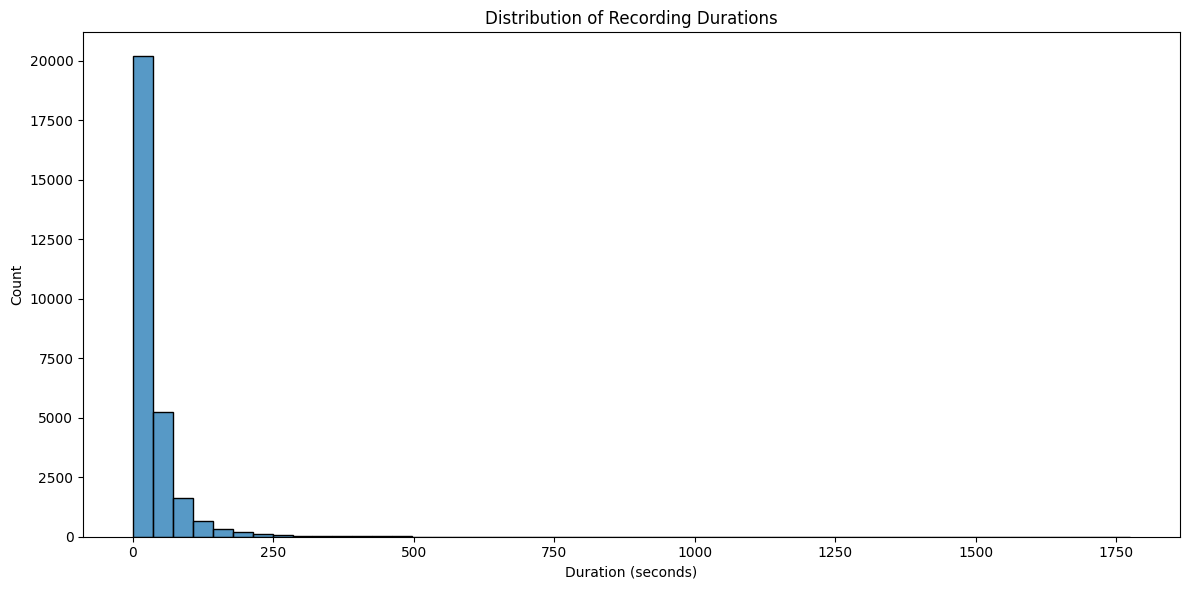

In [10]:
# visualize overall distribution
plt.figure(figsize=(12, 6))
sns.histplot(durations_df['duration'], bins=50)
plt.title('Distribution of Recording Durations')
plt.xlabel('Duration (seconds)')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

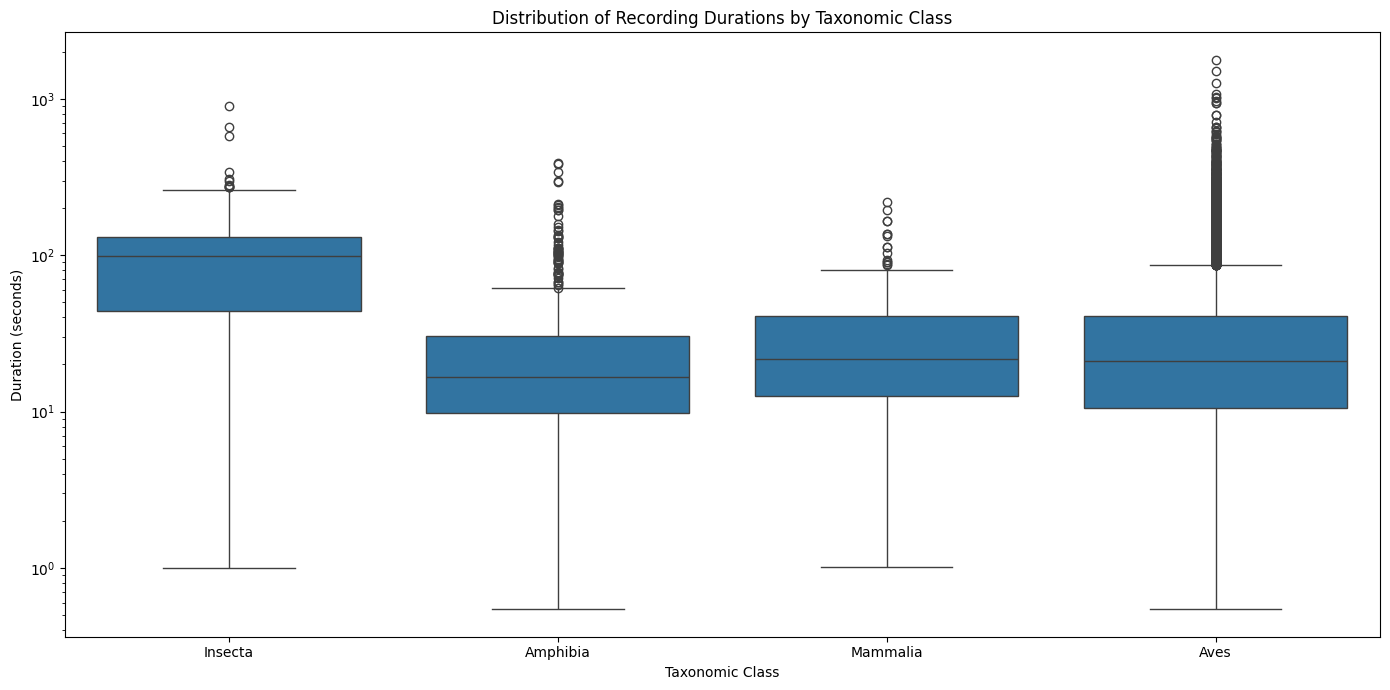

In [11]:
# duration statistics by taxonomic class
plt.figure(figsize=(14, 7))
sns.boxplot(x='class_name', y='duration', data=durations_df)
plt.title('Distribution of Recording Durations by Taxonomic Class')
plt.xlabel('Taxonomic Class')
plt.ylabel('Duration (seconds)')
plt.yscale('log')
plt.tight_layout()
plt.show()

In [12]:
# calculate statistics by taxonomic class
class_duration_stats = durations_df.groupby('class_name').agg(
    count = ('duration', 'count'),
    min_duration = ('duration', 'min'),
    max_duration = ('duration', 'max'),
    mean_duration = ('duration', 'mean'),
    median_duration = ('duration', 'median'),
    std_duration = ('duration', 'std')
).reset_index()

print('Duration statistics by taxonomic class:')
print(class_duration_stats)

Duration statistics by taxonomic class:
  class_name  count  min_duration  max_duration  mean_duration  \
0   Amphibia    583      0.544594    389.773062      30.358085   
1       Aves  27648      0.548000   1774.392000      35.028030   
2    Insecta    155      0.994375    896.575094     113.759901   
3   Mammalia    178      1.018000    218.784000      33.827185   

   median_duration  std_duration  
0        16.555844     43.964487  
1        21.013703     49.887340  
2        99.418906    114.625816  
3        21.762922     35.446242  


In [13]:
# indentify very long and very short recordings
very_short = durations_df[durations_df['duration'] < 1.0]
very_long = durations_df[durations_df['duration'] > 60.0]

print(f"Number of very short recordings (<1s): {len(very_short)}")
print(f"Number of very long recordings (>60s): {len(very_long)}")

Number of very short recordings (<1s): 24
Number of very long recordings (>60s): 4282


In [14]:
# save the duration data
durations_df.to_csv('../data/interim/audio_durations.csv', index=False)